# 🎨 BRK-A-01 Results Visualization

Notebook per la visualizzazione 3D avanzata dei risultati di topology optimization.

**Input:** Risultati salvati da `main.py` in `data/brk_a_01/`

---

## 1. Setup e Import

In [1]:
import sys
sys.path.insert(0, '..')

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 3D Visualization
try:
    import pyvista as pv
    pv.set_jupyter_backend('static')  # Use 'trame' for interactive
    PYVISTA_AVAILABLE = True
    print("✓ PyVista disponibile per visualizzazione 3D avanzata")
except ImportError:
    PYVISTA_AVAILABLE = False
    print("⚠ PyVista non installato. Installa con: pip install pyvista")

try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✓ Plotly disponibile per visualizzazione interattiva")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠ Plotly non installato. Installa con: pip install plotly")

print("\nImports completati ✓")

✓ PyVista disponibile per visualizzazione 3D avanzata
✓ Plotly disponibile per visualizzazione interattiva

Imports completati ✓


## 2. Carica Risultati da main.py

In [2]:
# Percorso ai risultati
data_dir = Path('../data/brk_a_01')

# Carica metadata
with open(data_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

# Carica campo di densità
density = np.load(data_dir / 'density_field.npy')

# Mostra informazioni
print("📂 Risultati caricati da:", data_dir)
print("\n📊 Metadata:")
for key, value in metadata.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")

print(f"\n📐 Campo densità:")
print(f"   Shape: {density.shape}")
print(f"   Min: {density.min():.4f}")
print(f"   Max: {density.max():.4f}")
print(f"   Mean: {density.mean():.4f}")

📂 Risultati caricati da: ../data/brk_a_01

📊 Metadata:
   case: BRK-A-01
   resolution_mm: 3.0000
   domain_shape: [40, 20, 26]
   volume_fraction_target: 0.2500
   volume_fraction_final: 0.2500
   compliance_final: 0.1149
   iterations: 50
   converged: False
   elapsed_time_s: 2557.5595

📐 Campo densità:
   Shape: (40, 20, 26)
   Min: 0.0100
   Max: 1.0000
   Mean: 0.2500


## 3. Slice Views (Matplotlib)

/var/folders/j4/lw9rt9517k134dz28rgq71r40000gn/T/ipykernel_95573/3492871582.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


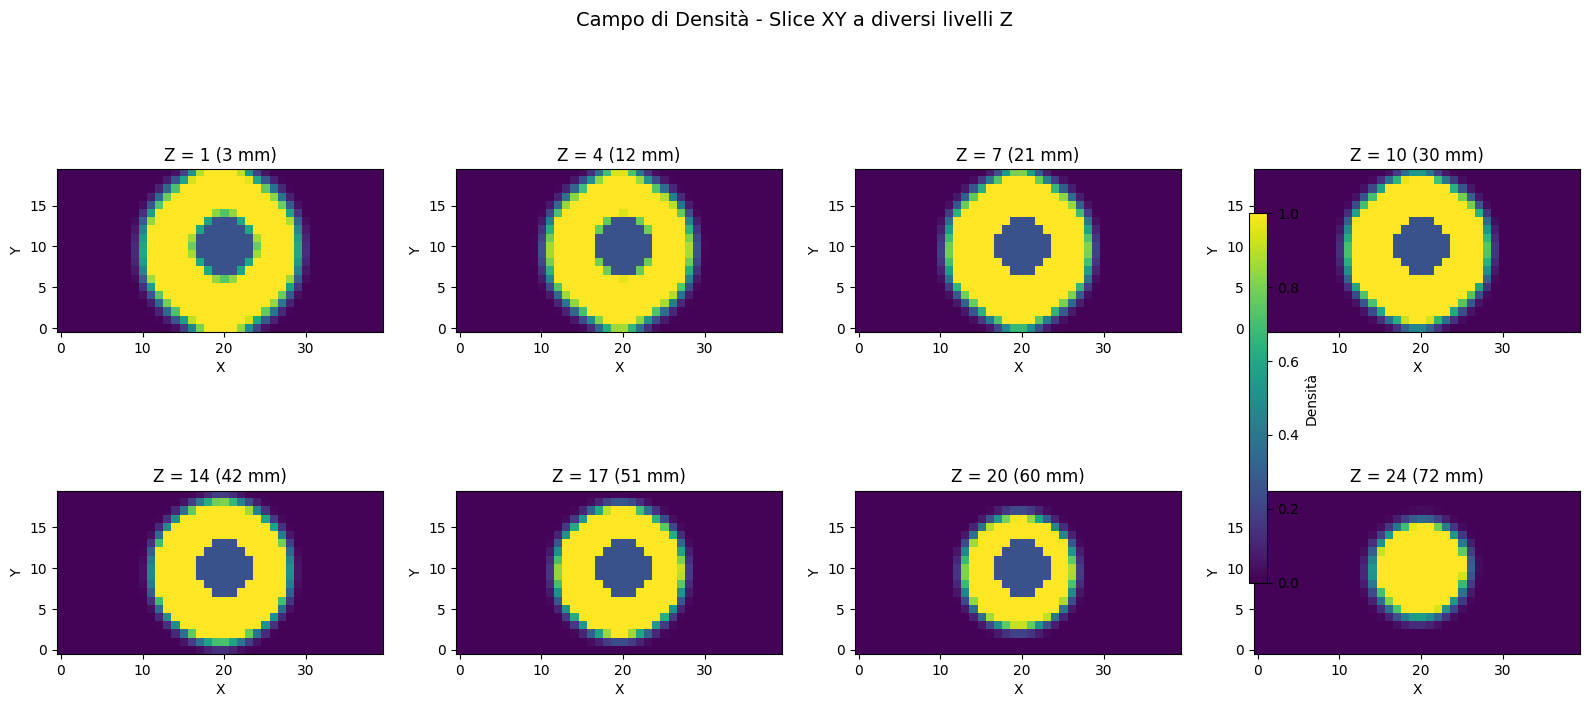

In [3]:
# Visualizza slice a diversi livelli
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

nz = density.shape[2]
z_levels = np.linspace(1, nz-2, 8).astype(int)

for ax, z in zip(axes.flat, z_levels):
    im = ax.imshow(density[:, :, z].T, cmap='viridis', 
                   vmin=0, vmax=1, origin='lower', aspect='equal')
    ax.set_title(f'Z = {z} ({z * metadata["resolution_mm"]:.0f} mm)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.colorbar(im, ax=axes, label='Densità', shrink=0.6)
plt.suptitle('Campo di Densità - Slice XY a diversi livelli Z', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Isosurface 3D con Matplotlib

/var/folders/j4/lw9rt9517k134dz28rgq71r40000gn/T/ipykernel_95573/1932031059.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


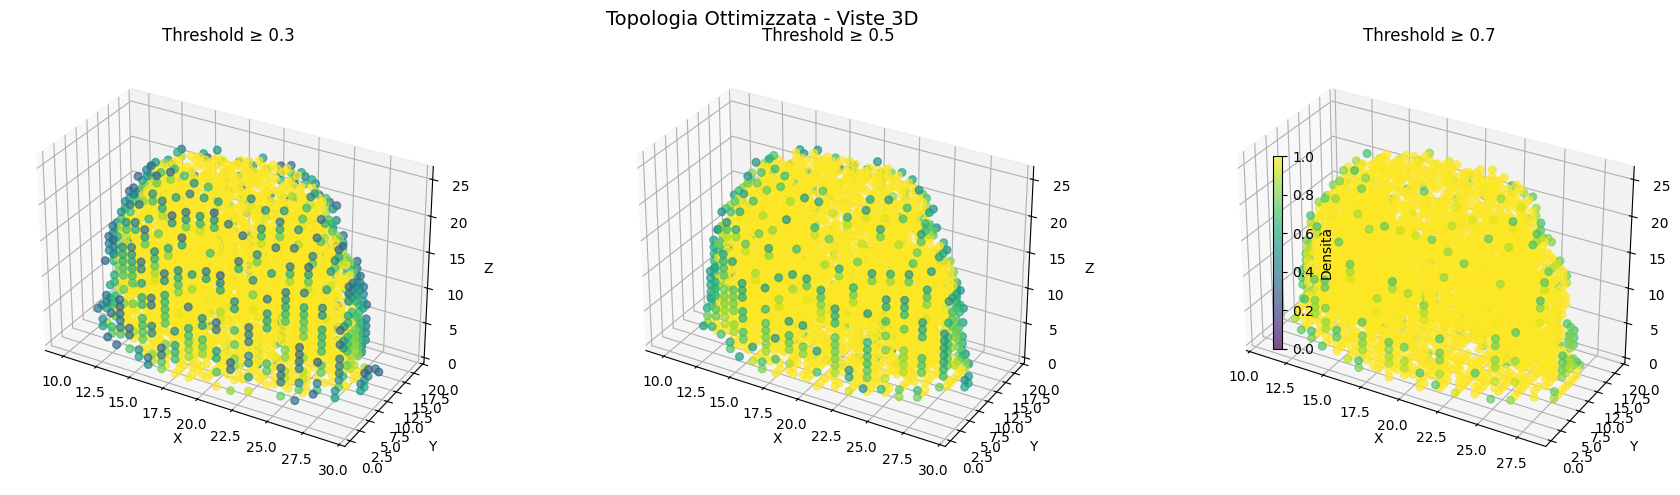

Threshold 0.3: 4,970 voxel (23.9%)
Threshold 0.5: 4,564 voxel (21.9%)
Threshold 0.7: 4,185 voxel (20.1%)


In [4]:
from mpl_toolkits.mplot3d import Axes3D

# Estrai voxel solidi a diverse soglie
thresholds = [0.3, 0.5, 0.7]

fig = plt.figure(figsize=(18, 5))

for idx, threshold in enumerate(thresholds):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    
    solid = density >= threshold
    x, y, z = np.where(solid)
    
    # Subsampling per performance
    max_points = 3000
    if len(x) > max_points:
        idx_sample = np.random.choice(len(x), max_points, replace=False)
        x, y, z = x[idx_sample], y[idx_sample], z[idx_sample]
    
    colors = density[x, y, z]
    scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', 
                         s=30, alpha=0.7, vmin=0, vmax=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Threshold ≥ {threshold}')
    ax.set_box_aspect([density.shape[0], density.shape[1], density.shape[2]])

plt.colorbar(scatter, ax=fig.axes, label='Densità', shrink=0.5)
plt.suptitle('Topologia Ottimizzata - Viste 3D', fontsize=14)
plt.tight_layout()
plt.show()

# Statistiche
for t in thresholds:
    n_solid = np.sum(density >= t)
    pct = n_solid / density.size * 100
    print(f"Threshold {t}: {n_solid:,} voxel ({pct:.1f}%)")

## 5. Visualizzazione 3D Avanzata con PyVista

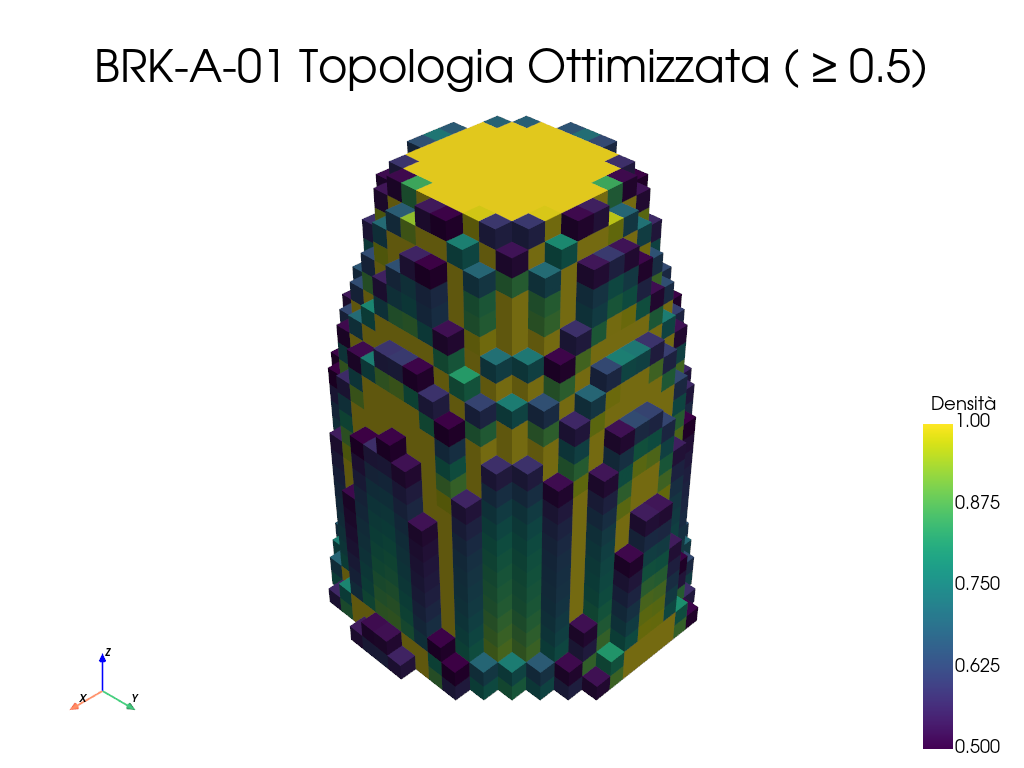

In [5]:
if PYVISTA_AVAILABLE:
    # Crea griglia strutturata
    resolution = metadata['resolution_mm']
    nx, ny, nz = density.shape
    
    # Crea coordinate per la griglia
    x = np.arange(0, (nx + 1) * resolution, resolution)
    y = np.arange(0, (ny + 1) * resolution, resolution)
    z = np.arange(0, (nz + 1) * resolution, resolution)
    
    # Crea ImageData (griglia uniforme)
    grid = pv.ImageData(
        dimensions=(nx + 1, ny + 1, nz + 1),
        spacing=(resolution, resolution, resolution),
        origin=(0, 0, 0)
    )
    
    # Aggiungi densità come dati delle celle
    grid.cell_data['density'] = density.flatten(order='F')
    
    # Threshold per estrarre solo materiale solido
    threshold = 0.5
    solid = grid.threshold(threshold, scalars='density')
    
    # Plotter
    pl = pv.Plotter()
    pl.add_mesh(solid, scalars='density', cmap='viridis', 
                show_edges=False, opacity=1.0,
                scalar_bar_args={'title': 'Densità', 'vertical': True})
    pl.add_axes()
    pl.add_title(f'BRK-A-01 Topologia Ottimizzata (ρ ≥ {threshold})')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile. Installa con: pip install pyvista")

## 6. Isosurface con PyVista

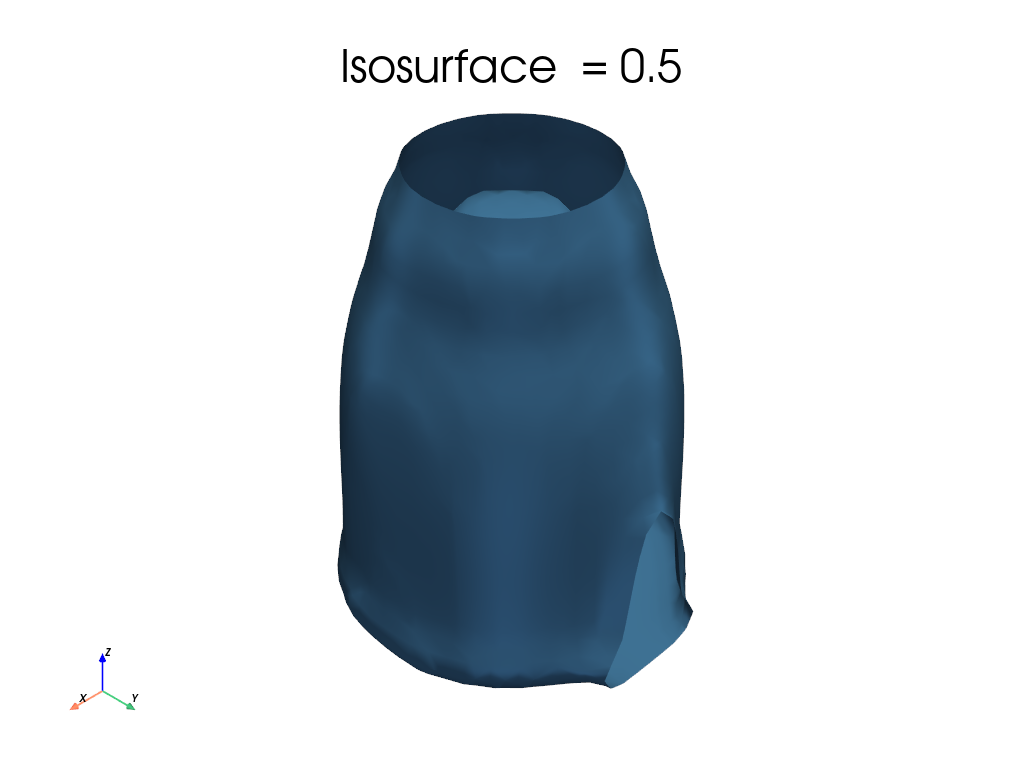

In [6]:
if PYVISTA_AVAILABLE:
    # Converti cell data a point data per isosurface smooth
    grid_points = grid.cell_data_to_point_data()
    
    # Genera isosurface a ρ = 0.5
    iso_value = 0.5
    isosurface = grid_points.contour([iso_value], scalars='density')
    
    # Smooth per migliorare qualità visiva
    isosurface_smooth = isosurface.smooth(n_iter=50)
    
    # Plot
    pl = pv.Plotter()
    pl.add_mesh(isosurface_smooth, color='steelblue', 
                show_edges=False, smooth_shading=True,
                specular=0.5, specular_power=20)
    pl.add_axes()
    pl.add_title(f'Isosurface ρ = {iso_value}')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile")

## 7. Multi-Isosurface (Visualizzazione Gradiente)

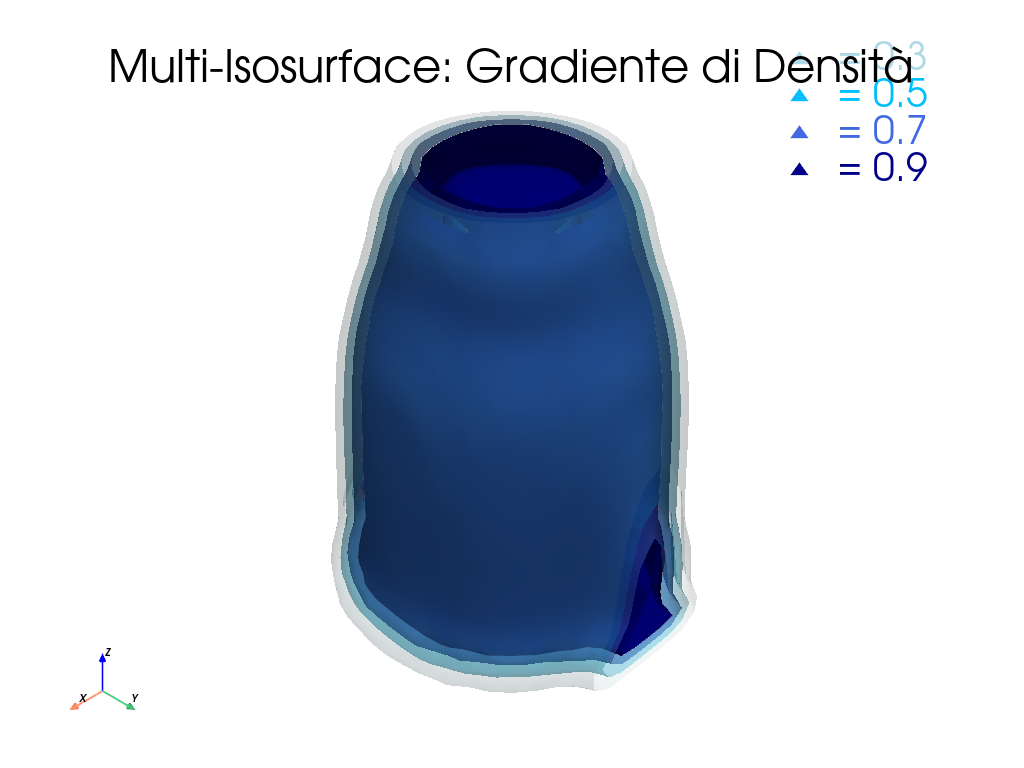

In [7]:
if PYVISTA_AVAILABLE:
    pl = pv.Plotter()
    
    # Isosurfaces a diversi livelli con opacità crescente
    iso_levels = [0.3, 0.5, 0.7, 0.9]
    opacities = [0.15, 0.3, 0.6, 1.0]
    colors = ['lightblue', 'deepskyblue', 'royalblue', 'darkblue']
    
    for iso_val, opacity, color in zip(iso_levels, opacities, colors):
        try:
            iso = grid_points.contour([iso_val], scalars='density')
            if iso.n_points > 0:
                iso_smooth = iso.smooth(n_iter=30)
                pl.add_mesh(iso_smooth, color=color, opacity=opacity,
                            smooth_shading=True, label=f'ρ = {iso_val}')
        except Exception as e:
            print(f"Skip iso {iso_val}: {e}")
    
    pl.add_axes()
    pl.add_legend()
    pl.add_title('Multi-Isosurface: Gradiente di Densità')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile")

## 8. Visualizzazione Interattiva con Plotly

In [8]:
if PLOTLY_AVAILABLE:
    # Estrai voxel con densità > threshold
    threshold = 0.5
    resolution = metadata['resolution_mm']
    
    x, y, z = np.where(density >= threshold)
    values = density[x, y, z]
    
    # Converti in mm
    x_mm = x * resolution
    y_mm = y * resolution
    z_mm = z * resolution
    
    # Subsampling per performance
    max_points = 5000
    if len(x_mm) > max_points:
        idx = np.random.choice(len(x_mm), max_points, replace=False)
        x_mm, y_mm, z_mm, values = x_mm[idx], y_mm[idx], z_mm[idx], values[idx]
    
    # Crea scatter 3D
    fig = go.Figure(data=[go.Scatter3d(
        x=x_mm, y=y_mm, z=z_mm,
        mode='markers',
        marker=dict(
            size=4,
            color=values,
            colorscale='Viridis',
            colorbar=dict(title='Densità'),
            opacity=0.8
        ),
        hovertemplate='X: %{x:.1f} mm<br>Y: %{y:.1f} mm<br>Z: %{z:.1f} mm<br>ρ: %{marker.color:.3f}<extra></extra>'
    )])
    
    fig.update_layout(
        title=f'BRK-A-01 Topologia Ottimizzata (ρ ≥ {threshold})',
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            aspectmode='data'
        ),
        width=900,
        height=700
    )
    
    fig.show()
else:
    print("⚠ Plotly non disponibile. Installa con: pip install plotly")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 9. Volume Rendering con PyVista

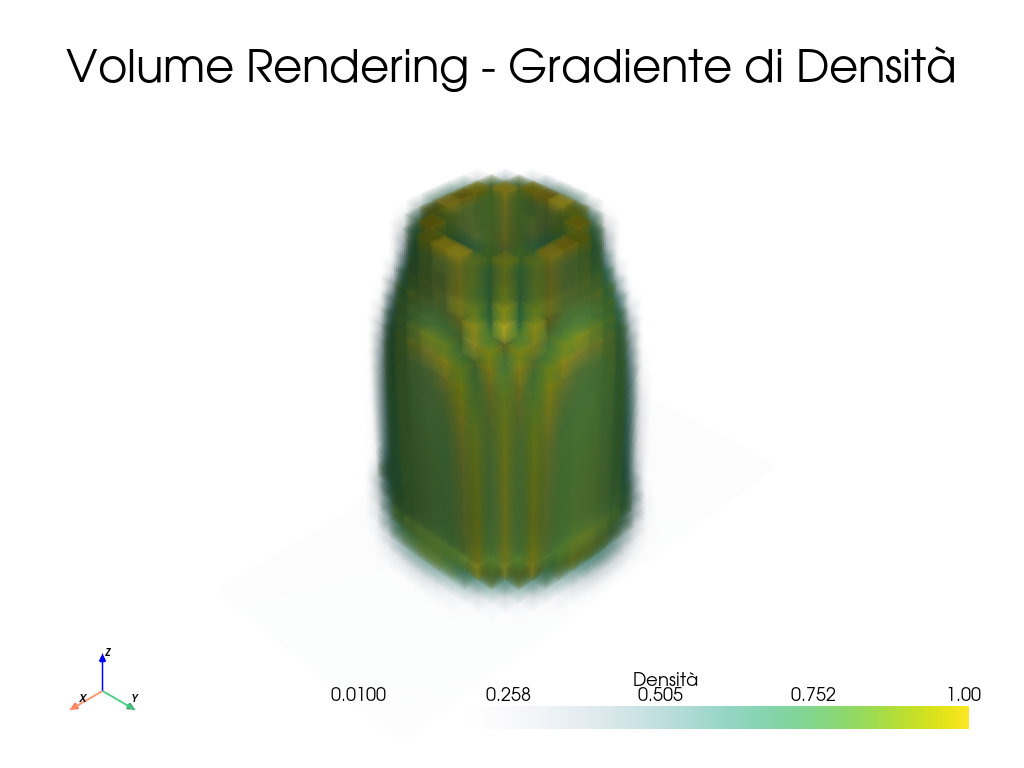

In [ ]:
if PYVISTA_AVAILABLE:
    # Volume rendering per visualizzare il gradiente interno
    pl = pv.Plotter()
    
    # Opacity transfer function
    opacity = [0, 0, 0.1, 0.3, 0.6, 0.9, 1.0]
    
    pl.add_volume(grid, scalars='density', cmap='viridis',
                  opacity=opacity, shade=True,
                  scalar_bar_args={'title': 'Densità'})
    pl.add_axes()
    pl.add_title('Volume Rendering - Gradiente di Densità')
    pl.camera_position = 'iso'
    pl.show()
else:
    print("⚠ PyVista non disponibile")

## 11. Export STL per Stampa 3D

In [ ]:
if PYVISTA_AVAILABLE:
    # Genera mesh STL dalla isosurface
    iso_value = 0.5
    
    # Genera isosurface
    grid_points = grid.cell_data_to_point_data()
    isosurface = grid_points.contour([iso_value], scalars='density')
    
    # Smooth e clean
    mesh_clean = isosurface.smooth(n_iter=50).clean()
    
    # Salva STL
    stl_path = data_dir / 'brk_a_01_optimized.stl'
    mesh_clean.save(stl_path)
    
    print(f"✅ Mesh STL salvata: {stl_path}")
    print(f"   Vertici: {mesh_clean.n_points:,}")
    print(f"   Facce: {mesh_clean.n_cells:,}")
    print(f"   Volume: {mesh_clean.volume:.2f} mm³")
    
    # Mostra preview
    pl = pv.Plotter()
    pl.add_mesh(mesh_clean, color='silver', show_edges=False,
                smooth_shading=True, specular=0.5)
    pl.add_axes()
    pl.add_title('Preview Mesh STL per AM')
    pl.show()
else:
    print("⚠ PyVista necessario per export STL")

---

## 📝 Note

- **PyVista** offre rendering 3D di alta qualità con isosurface, volume rendering e slice
- **Plotly** permette visualizzazioni interattive nel browser
- Per visualizzazione interattiva completa in PyVista, usa `pv.set_jupyter_backend('trame')`
- L'export STL genera mesh pronte per software di slicing (Cura, PrusaSlicer, etc.)